In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load & Preprocess Data
df = pd.read_csv("NSE-TATAGLOBAL.csv")
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


In [3]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [5]:
df.shape

(2035, 8)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

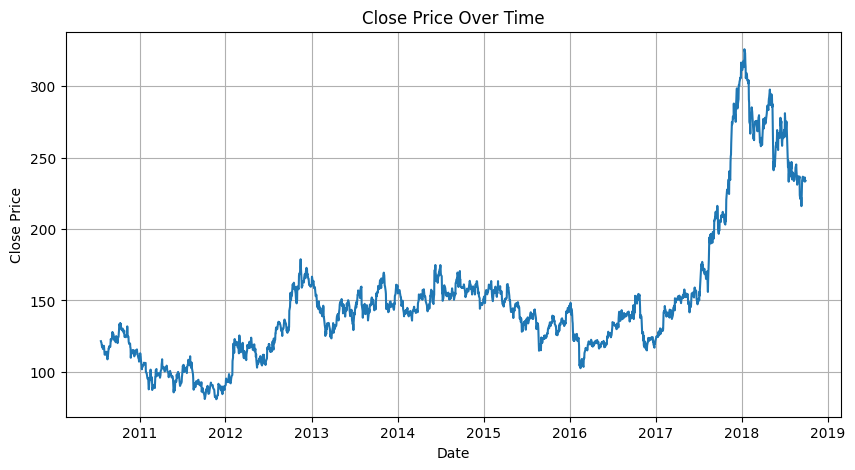

In [7]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

In [8]:
# Use Close prices
close_data = df[['Close']].copy()
train_size = int(len(close_data) * 0.9)
train = close_data.iloc[:train_size]
test = close_data.iloc[train_size:]

In [9]:
# ARIMA
arima_model = ARIMA(train, order=(5, 1, 0)).fit()
arima_pred = arima_model.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [10]:
# Evaluate
arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
arima_mae = mean_absolute_error(test, arima_pred)

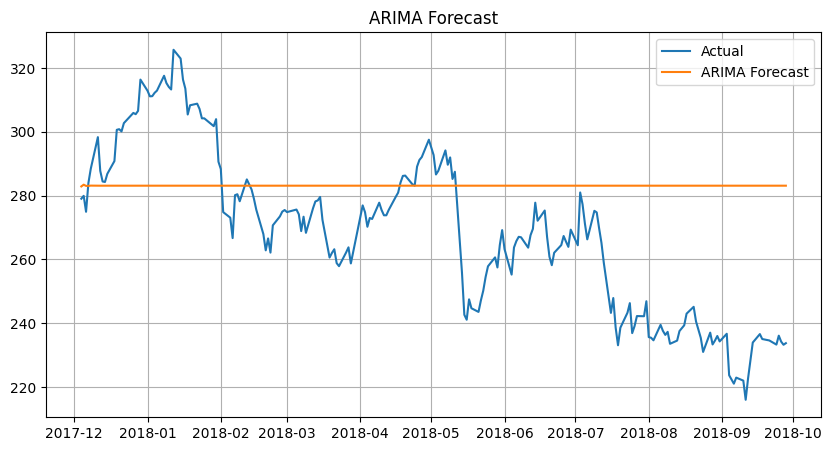

In [11]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_pred, label='ARIMA Forecast')
plt.title("ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
#SARIMA
sarima_model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 5)).fit(disp=False)
sarima_pred = sarima_model.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [13]:
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_pred))
sarima_mae = mean_absolute_error(test, sarima_pred)

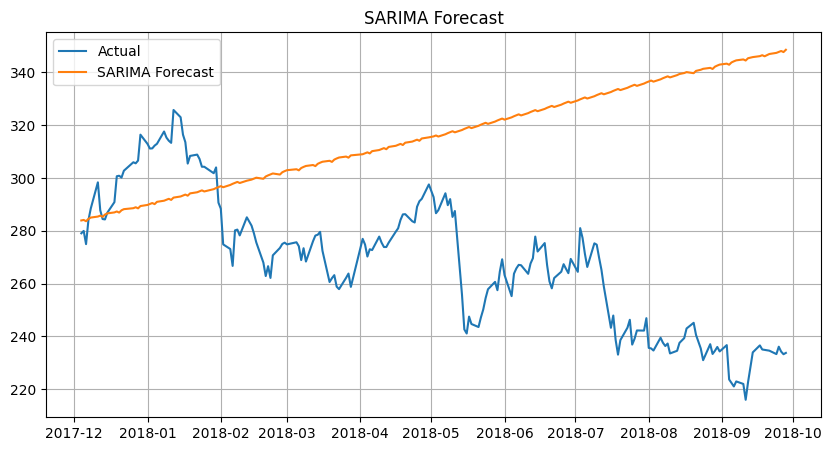

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, sarima_pred, label='SARIMA Forecast')
plt.title("SARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Prophet
prophet_df = close_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]

In [16]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy8ee5t0u/mzxo2uxb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy8ee5t0u/5sl1oobf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32227', 'data', 'file=/tmp/tmpy8ee5t0u/mzxo2uxb.json', 'init=/tmp/tmpy8ee5t0u/5sl1oobf.json', 'output', 'file=/tmp/tmpy8ee5t0u/prophet_modelarx2opp2/prophet_model-20250729112612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:26:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
future = prophet.make_future_dataframe(periods=len(prophet_test))
forecast = prophet.predict(future)

In [18]:
# Evaluation
prophet_forecast = forecast.iloc[-len(test):]['yhat'].values
prophet_rmse = np.sqrt(mean_squared_error(test['Close'], prophet_forecast))
prophet_mae = mean_absolute_error(test['Close'], prophet_forecast)

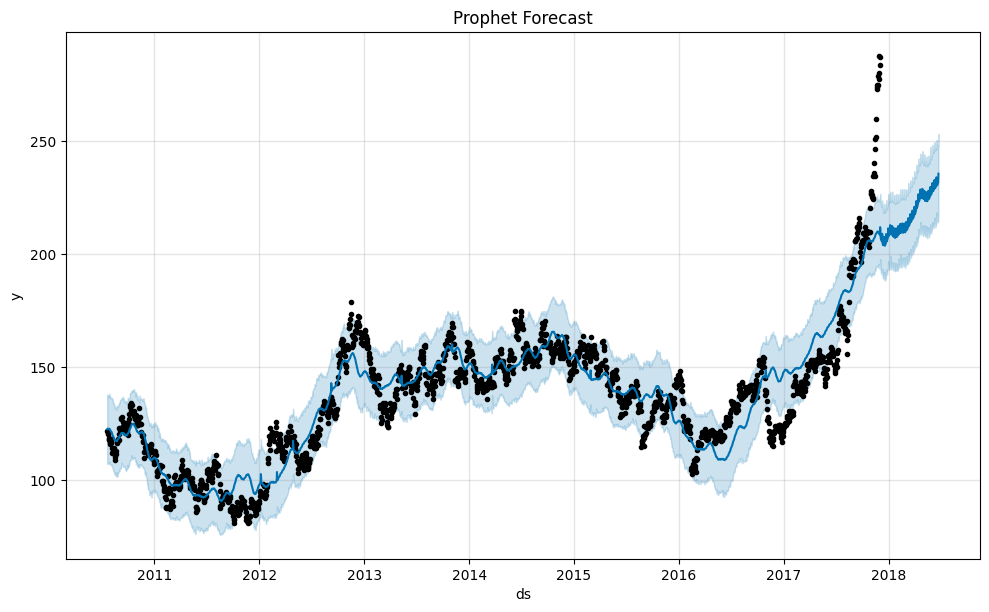

In [19]:
# Plot
prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

In [20]:
# 5. LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)

In [21]:
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

In [22]:
X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [23]:
# Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [26]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0178
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 7.4099e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 6.6733e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 5.9565e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 5.7299e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 5.2084e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 5.3938e-04
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 5.0658e-04
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.6576e-04
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 4.3639e-04


In [27]:
# Prepare test data
total_data = np.concatenate((train_scaled, test_scaled), axis=0)
inputs = total_data[len(total_data) - len(test_scaled) - 60:]
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [28]:
lstm_pred_scaled = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


In [29]:
# Evaluation
lstm_rmse = np.sqrt(mean_squared_error(test['Close'][-len(lstm_pred):], lstm_pred))
lstm_mae = mean_absolute_error(test['Close'][-len(lstm_pred):], lstm_pred)

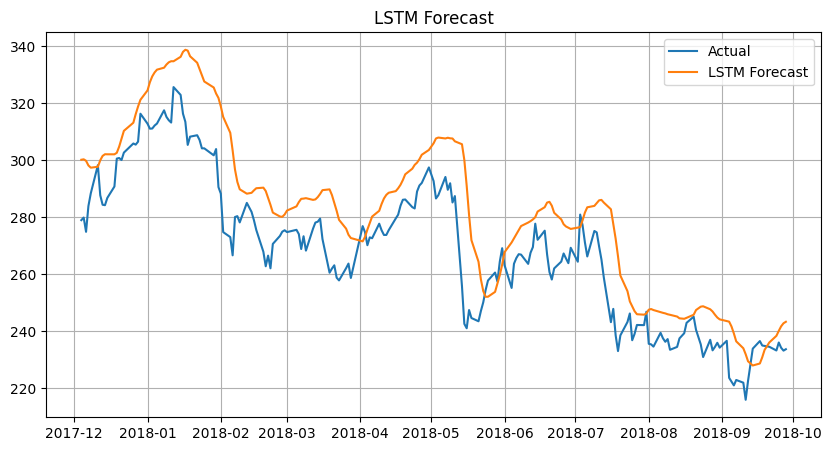

In [30]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(test.index[-len(lstm_pred):], test['Close'][-len(lstm_pred):], label='Actual')
plt.plot(test.index[-len(lstm_pred):], lstm_pred, label='LSTM Forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# 6. Summary of Results
print("Model Evaluation (Test Data)")
print(f"ARIMA:   RMSE = {arima_rmse:.2f}, MAE = {arima_mae:.2f}")
print(f"SARIMA:  RMSE = {sarima_rmse:.2f}, MAE = {sarima_mae:.2f}")
print(f"Prophet: RMSE = {prophet_rmse:.2f}, MAE = {prophet_mae:.2f}")
print(f"LSTM:    RMSE = {lstm_rmse:.2f}, MAE = {lstm_mae:.2f}")

Model Evaluation (Test Data)
ARIMA:   RMSE = 29.08, MAE = 23.63
SARIMA:  RMSE = 63.60, MAE = 52.90
Prophet: RMSE = 61.05, MAE = 52.35
LSTM:    RMSE = 17.01, MAE = 14.11
